In [1]:
import multiprocessing as mp
import netket as nk
import os
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec
import copy

In [2]:
#basis transfer fuction, from a basis of eigenstates to a basis of "basis states"
def transfer(state_eig, sta_list, eng_list, N):
    state_basis = np.zeros(2**N, dtype= 'complex128')
    for i in range(len(eng_list)):
        state_basis += state_eig[i] * sta_list[i]
    return state_basis #/ np.linalg.norm(state_basis)

def expected(A, norm_psi):
        
    expectation = np.dot(np.conj(norm_psi).T, np.matmul(A, norm_psi) )
    return expectation

In [3]:

#evolve the state vector itself, where sta_init is in the basis of the eigenstates, and all input states are np arrays. 
def evo_sta(sta_list, eng_list, t_end, t_step, sta_init, N):
    num_step = int(t_end / t_step)
    time = [0]
    state = [transfer(sta_init, sta_list, eng_list, N).reshape(2**N,1)]
    state_temp = copy.deepcopy(sta_init)
    for i in range(num_step):
        time.append(t_step*(i+1))
        
        for j in range(len(eng_list)):
            op = np.exp(- 1j * eng_list[j] * t_step)
            state_temp[j] = op * state_temp[j]
            
        state.append(transfer(state_temp, sta_list, eng_list, N).reshape(2**N,1))
        
    return time, state
        
    
    
#evolve the expectation value
def evo_exp(time, state, obs):
    obser = []
    for i in range(len(time)):
        obser.append(expected(obs,state[i])[0])
 
    return obser
        
    

In [4]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

#input_basis directly from output of exact_diagnolization, input_vec as np array object
def basis_trans(input_vec, input_basis, N):
    vec_new = np.linalg.inv(np.array(v).reshape(2**N, 2**N).T).dot(input_vec.reshape(2**N, 1))
    return vec_new

In [5]:
N=3
B=0.95
A = N/2
N0 = N/2

Ak = []
for i in range(N-1):
        # Constant A
    #Ak_i = 1
        # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)

sx_list, sy_list, sz_list,id = operatorCreation(N)

obver = np.array(sz_list[0])

# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)

#Exact Diagonalization
e, v= exactDiagonalization_full(ha)
#Ground state energy
edEng = e[0]
# Ground state
edState = v[0]

#Make initial State
#psi0 = coherent(2**N,3)
psi0 = basis_trans(np.array(coherent(2**N,3)), v, N)
#shit = tensor(basis(2,1), basis(2,0), basis(2,1))




In [6]:

time, state = evo_sta(v[:5], e[:5], 30, 0.01, psi0, N )
SZ = evo_exp(time, state, obver)


time_ex, state_ex = evo_sta(v, e, 30, 0.01, psi0, N )
SZ_ex = evo_exp(time_ex, state_ex, obver)


/home/victor/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


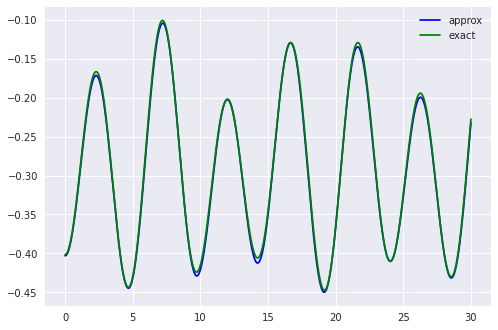

In [7]:
plt.plot(time, SZ, color='b', label = 'approx')
plt.plot(time_ex, SZ_ex, color='g', label = 'exact')
plt.legend()
plt.show()


In [8]:
a = basis_trans(np.array(coherent(2**N,3)), v, N).reshape(8,1)
print(a)

[[ 0.08799955+0.j]
 [ 0.33214451+0.j]
 [ 0.32340216+0.j]
 [ 0.728862  +0.j]
 [-0.48952123+0.j]
 [-0.07684267+0.j]
 [-0.0238655 +0.j]
 [ 0.00139153+0.j]]


In [168]:
a_ = [0,1]
def test(a):
    b = a
    b[0] = 1
    return b
c = test(a_)
print(c)
print(a_)

[1, 1]
[1, 1]


In [3]:
a = np.array([[1],[2],[3]])
print(np.linalg.norm(a))

3.7416573867739413
